Introduction
===============

PRISM provides precipitation data based on location, as far back as 1981.
This dataset was generated with the parameters:
* Location:  Lat: 35.5515   Lon: -97.4072   Elev: 1171ft
* Climate variables: ppt,tmin,tmean,tmax,tdmean,vpdmin,vpdmax
* Spatial resolution: 4km
* Period: 1981-01-01 - 2022-12-31
* Dataset: AN91d
* PRISM day definition: 24 hours ending at 1200 UTC on the day shown
* Grid Cell Interpolation: Off

This notebook is intended to demo the data analysis and data modelling process as a part of a portfolio. The ultimate goal is to be able to predict total precipitation (rain + melted snow). 
\
Feature Explanation
--------------------

| Name   | Description                                                                                                           | Units |
| ------ | --------------------------------------------------------------------------------------------------------------------- | ----- |
| ppt    | Total precipitation (rain+melted snow) for the day                                                                    | in    |
| tmin   | Minimum temperature for the day                                                                                       | F     |
| tmean  | Mean temperature for the day (tmax+tmin)/2                                                                            | F     |
| tmax   | Maximum temperature for the day                                                                                       | F     |
| tdmean | Mean dewpoint temperature (analogous to humidity and comfort)                                                         | F     |
| vpdmin | Minimum difference between the amount of vapor in the air, versus the total amount it can hold (relative to humidity) | hPa   |
| vpdmax | Maximum difference between the amount of vapor in the air, versus the total amount it can hold (relative to humidity) | hPa   |

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import utils
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
"""
First thing we want to do is read in the dataframe,
clean up the column names and move them in the order
that we want. We also want to decode the date and
extract the information from it.
"""
df = pd.read_csv("prism_ok_country_precip_data.csv")
col_names = ["date","precip","min_temp","mean_temp","max_temp","dewpoint","vpd_min","vpd_max"]
df.columns = col_names
df.loc[:,"year"] = pd.DatetimeIndex(df["date"]).year
df.loc[:,"month"] = pd.DatetimeIndex(df["date"]).month
df.loc[:,"day"] = pd.DatetimeIndex(df["date"]).day
df.loc[:,"jul_day"] = pd.DatetimeIndex(df["date"]).dayofyear
col_order = ["year","month","day","jul_day","min_temp","mean_temp","max_temp","dewpoint","vpd_min","vpd_max","precip"]
df = df.loc[:,col_order]
print(df)
df.info()
df.to_csv("rain.csv", index=False)

       year  month  day  jul_day  min_temp  mean_temp  max_temp  dewpoint  \
0      1981      1    1        1      36.8       49.6      62.5      30.2   
1      1981      1    2        2      28.0       41.6      55.2      24.4   
2      1981      1    3        3      26.2       40.7      55.1      27.5   
3      1981      1    4        4      20.0       33.0      45.9      22.1   
4      1981      1    5        5      20.2       31.0      41.9      14.8   
...     ...    ...  ...      ...       ...        ...       ...       ...   
15335  2022     12   27      361      16.2       31.2      46.1      16.3   
15336  2022     12   28      362      18.1       34.5      50.9      21.2   
15337  2022     12   29      363      43.8       55.8      67.9      39.0   
15338  2022     12   30      364      34.3       50.3      66.3      32.1   
15339  2022     12   31      365      31.1       44.0      56.8      33.3   

       vpd_min  vpd_max  precip  
0         2.10    13.32     0.0  
1      

Date
1983-10-20    5.51
2010-06-15    6.16
2013-06-01    7.11
2021-06-27    5.38
Name: ppt (inches), dtype: float64


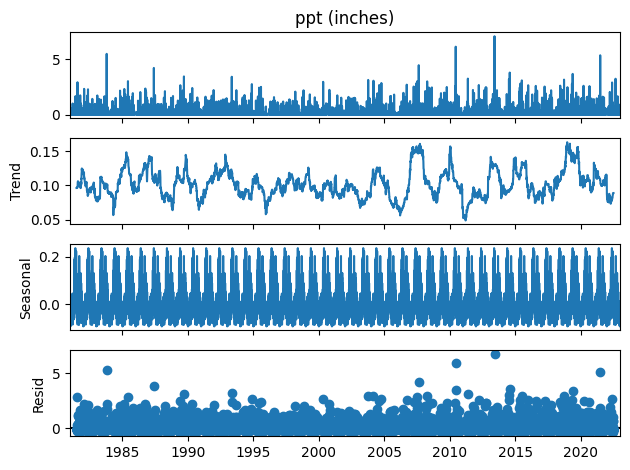

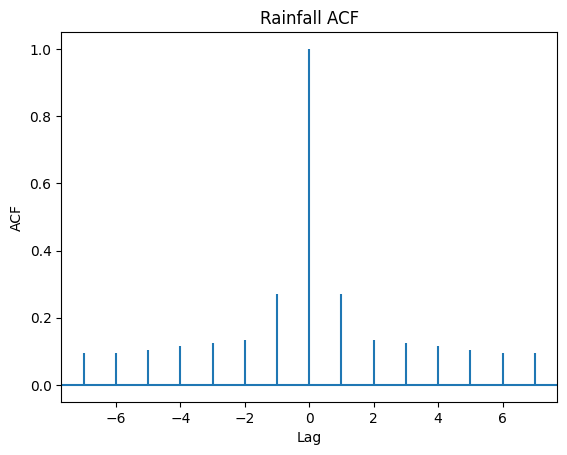

In [43]:
"""
We can time series decompose the actual
precipitation data by itself. This will
give us a good idea of the overall rainfall
behavior over the time that we have. We can
draw some conclusions right away, as this
data has no noise and no missing values.
"""
df = pd.read_csv("prism_ok_country_precip_data.csv")
ts_df = df.loc[:,"ppt (inches)"]
ts_df.index = pd.DatetimeIndex(df["Date"])
ts = seasonal_decompose(ts_df, period=365)
print(ts_df[ts_df >= 5.0])
ts.plot()
plt.show()
plt.acorr(df["ppt (inches)"].to_numpy(), maxlags=7) # max lag of a week
plt.title("Rainfall ACF")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

Time Series Analysis
======================
First, in the observed plot (top plot of the TS decomp) we see a few significant spikes in recent history. Starting in 2010, then again in 2013 and 2021. These years all had days with 5+ inches of rain in a single day. Within our dataset, there is only one other insance of this which was in 1983. That is a 27 year gap between the first two instances and only 11 years for the next three combined. This phenomena could indicate a recent increase in days with extreme rainfall in the last 15 years. The last three occurrences all happened in June, which is in the middle of tornado season. Tornado season is often accompanied by floods, which is why the values are so high.
\
\
The trend graph seems to imply a similar behavior. We see a lot of high amplitude changes from about 1984 to 1996. From about 1996 to 2006 we see much smaller changes, an almost flat line considering the y-scale. Then from about 2006 to the present we see another set or high amplitude changes. This might indicate a larger trend of 10-15 years of highly variable rainfall, followed by 8-10 years of stable rainfall and then it repeats. We would need maybe another 20 years of data to confidently point out this trend though. If the trend is true, we are currently (in 2024) 3 years into an 8-10 year period of stable rainfall. This could be useful information to farmers, for example, as they could rotate crops based on water demands accordingly.
\
\
Finally, the  autocorrelation function (ACF) plot tells us something about how rainfall in Oklahoma county is dependent on the previous days. In the plot, we can see significant components (about 0.3) of correlation with a lag of 1 day and then a sharp dropoff from there. In other words, about 30% of the variance in daily rainfall in Oklahoma County can be explained by whether it rained the previous day. This means that the answer to the question "How much rain will we get today?" has some dependence on how much rain we got yesterday, but little depence on how much rain we got two days ago or the days before that. This is useful information for anyone that is interested in forecasting precipitation totals in OK County.

In [27]:
"""
Now we can start to look at the condition of the
data, as well as some descriptive stats.
"""
df = pd.read_csv("rain.csv")
print(df.describe())

       Unnamed: 0          year         month           day       jul_day  \
count  15340.0000  15340.000000  15340.000000  15340.000000  15340.000000   
mean    7669.5000   2001.500326      6.523077     15.729205    183.119296   
std     4428.4209     12.120919      3.448775      8.800196    105.438628   
min        0.0000   1981.000000      1.000000      1.000000      1.000000   
25%     3834.7500   1991.000000      4.000000      8.000000     92.000000   
50%     7669.5000   2001.500000      7.000000     16.000000    183.000000   
75%    11504.2500   2012.000000     10.000000     23.000000    274.000000   
max    15339.0000   2022.000000     12.000000     31.000000    366.000000   

           min_temp     mean_temp      max_temp      dewpoint       vpd_min  \
count  15340.000000  15340.000000  15340.000000  15340.000000  15340.000000   
mean      50.128038     60.747106     71.371076     47.666173      2.192583   
std       17.919648     17.958043     18.687281     17.427147      2.

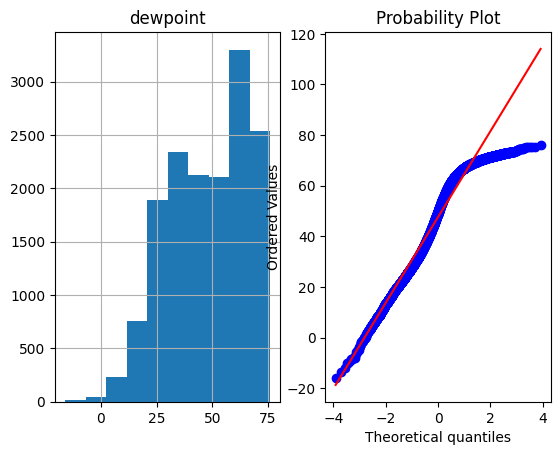

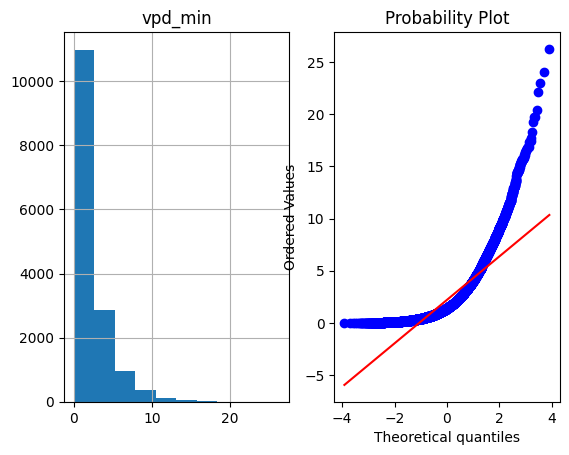

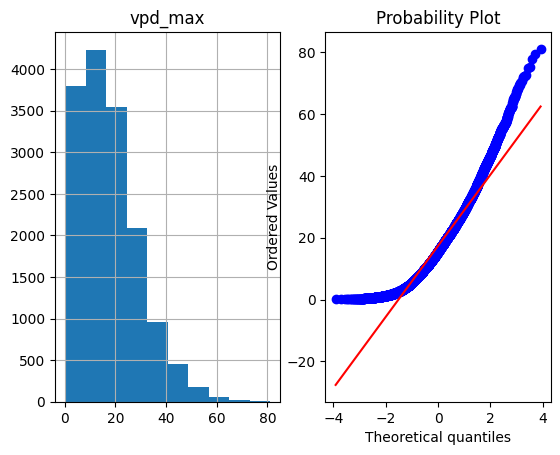

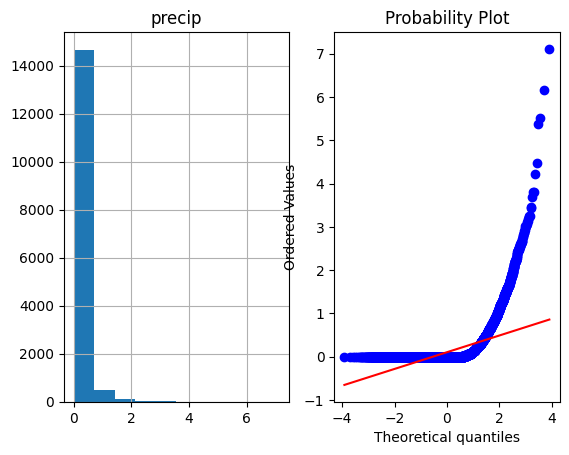

In [15]:
"""
We can see the temperatures seem to be within reasonable ranges.
This information is for Oklahoma County and as a resident I can
use subject knowledge to say that the temperatures are within
reason. If any outliers are present, they are not errors and are
true data points that happen to be outliers.

The dewpoint and VPD min/max are something I do not have subject
knowledge of. So we will take a closer look at these to see the
spreads.

We can also see from the quantiles that the precipitation is
right-skewed and there may be some high outliers. We are not
concerned about fixing the skew, as this is our target 
variable, but we need to make concious choices when splitting
the data.
"""
df = pd.read_csv("rain.csv")
cols = ["dewpoint","vpd_min","vpd_max","precip"]

for c in cols:
    utils.hist_prob_plots(df, c)

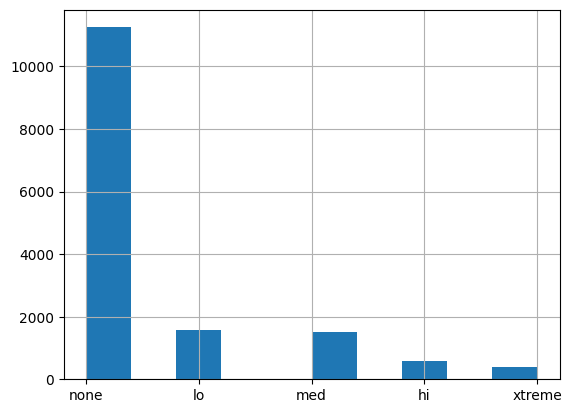

In [24]:
"""
As expected, these values are skewed and have outliers.
First, we will handle the target variable. We will
create a new "meta-target" that will classify the precip
into "none","lo","med","hi" and "xtreme". This will give
us reference points to use when splitting our dataset.
"""

def label_col(df, ranges, col):
    colname = f"{col}_level"
    df.loc[:,colname] = np.full(shape=(df.shape[0],), fill_value="")
    for label in ranges:
        lb = ranges[label][0]
        ub = ranges[label][1]
        df.loc[(df[col] > lb) & (df[col] <= ub),colname] = label
    return df

ranges = {"none": [-np.inf,0.0],
          "lo": [0.0,0.1],
          "med": [0.1,0.5],
          "hi": [0.5,1.0],
          "xtreme": [1.0,np.inf]}

df = label_col(df, ranges, "precip")
df["precip_level"].hist()
plt.show()
df.to_csv("rain.csv")

In [ ]:
"""
Now that the labels are created, we can take a look at the
input features which we determined to be skewed.
"""
df = pd.read_csv("rain.csv")
cols = ["dewpoint","vpd_min","vpd_max"]